**Dimensional analysis with Dadapy**

In this notebook we are performing the dimensional analysis of the embedding space with dadapy. These algorithms estimate the intrinsic dimension of the data manifold, i.e. the minimum number of coordinates needed to describe the manifold without a significant loss of information. In the following code two techniques are implemented:
- Two NN
- Gride 


In [2]:
import matplotlib.pyplot as plt 
import torch 
from dadapy import Data
import numpy as np 
import seaborn as sns
from matplotlib.gridspec import GridSpec
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph
import random 

In [5]:
# Layers

'''
Decoder_01_FirstNormalization  = output_list[3]
Decoder_01_QKV_representation  = output_list[4]
Decoder_01_AttentionHeads      = output_list[5]
Decoder_01_AttentionProj       = output_list[7]
Decoder_01_SecondNormalization = output_list[9]
Decoder_01_FirstLayerNN        = output_list[11]
Decoder_01_SecondLayerNN       = output_list[13]
'''

string = ['FirstNormalization', 'AttentionProj', 'SecondNormalization', 'SecondLayerNN']


vector = torch.load("output/decoder/decoder_1/FirstNormalization.pt").detach().numpy()[0]
#print(vectors, type(vector))

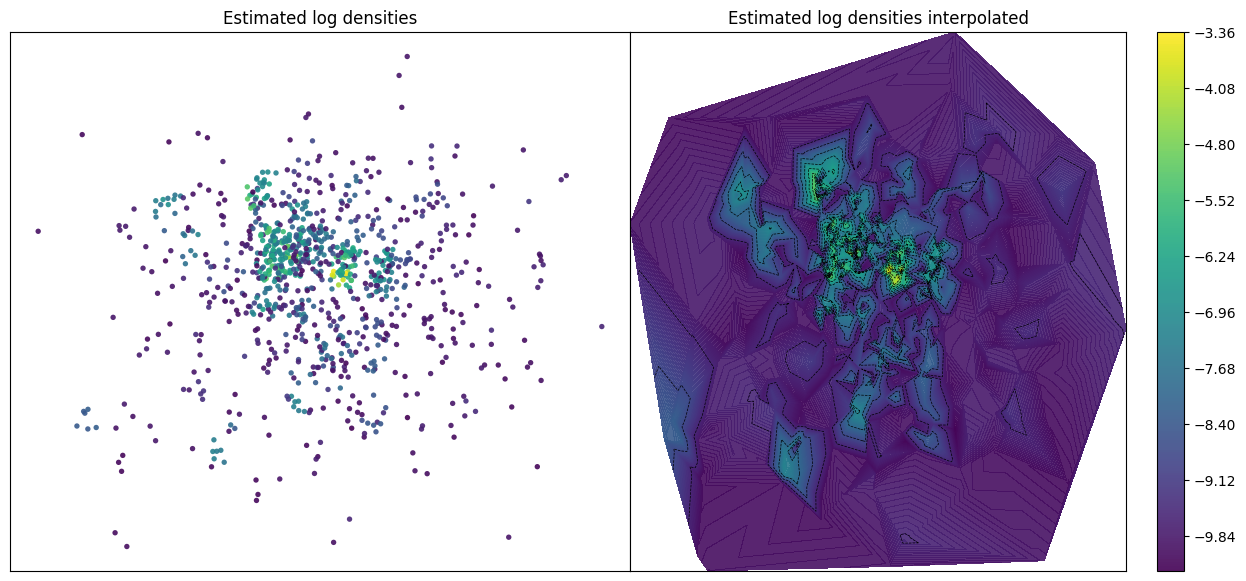

In [24]:
data = Data(vector)
data.compute_id_2NN()
#data.compute_density_kstarNN()
#data.compute_density_PAk()
data.compute_density_kNN(k = 5) # k is a parameter going from 0 to 100 used to perform the clustering of the data 
# How can it be chosen? 
# k is the number of neighbours used to compute the density -- non so quale potrebbe essere più utile per l'area semantica


X = vector 
f, [ax1, ax2] = plt.subplots(
    1, 2, figsize=(16, 7), gridspec_kw={"hspace": 0.05, "wspace": 0}
)
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.set_title("Estimated log densities")

ax1.scatter(X[:, 0], X[:, 1], s=15.0, alpha=0.9, c=data.log_den, linewidths=0.0)
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.set_title("Estimated log densities interpolated")
ax2.tricontour(X[:, 0], X[:, 1], data.log_den, levels=10, linewidths=0.5, colors="k")
fig2 = ax2.tricontourf(X[:, 0], X[:, 1], data.log_den, levels=250, alpha=0.9)

plt.colorbar(fig2)
plt.show()

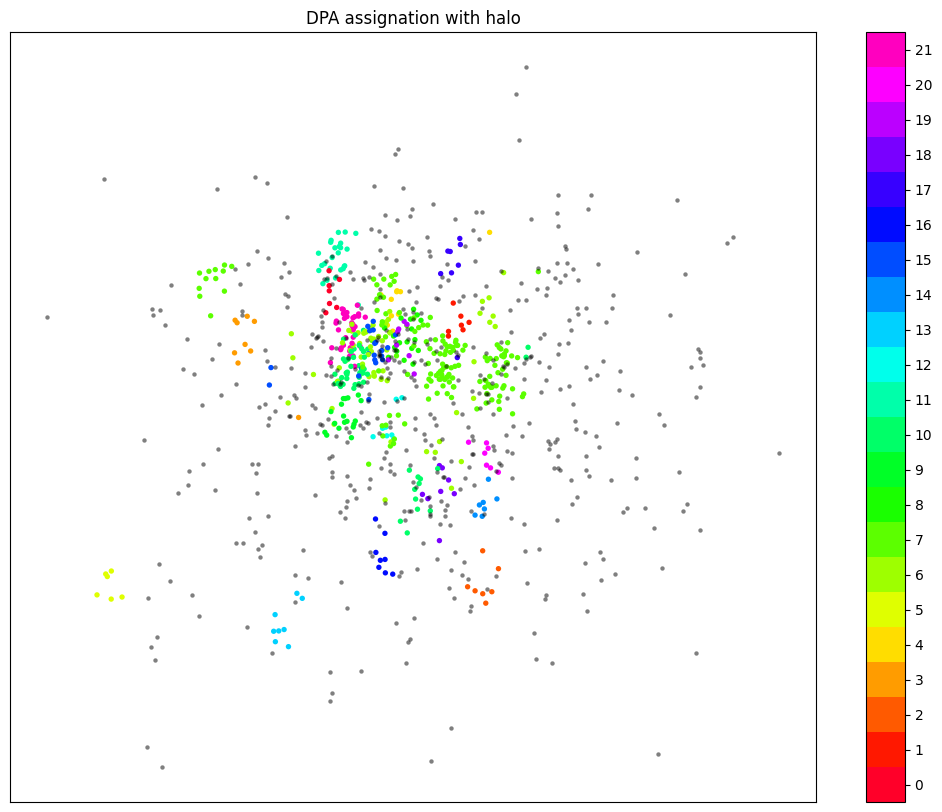

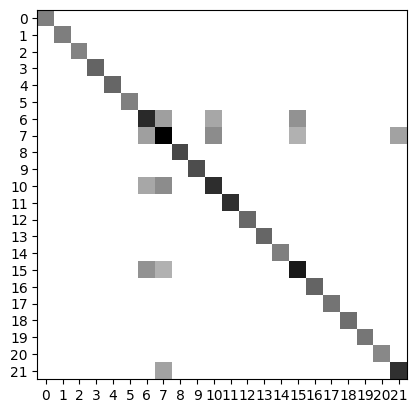

In [26]:
data.compute_clustering_ADP(Z=4.0, halo=True) 
# Che cos'è halo??  


Nclus_m = len(data.cluster_centers)
cmap = plt.get_cmap("gist_rainbow", Nclus_m)
f, ax = plt.subplots(1, 1, figsize=(13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title("DPA assignation with halo")
xdtmp = []
ydtmp = []
ldtmp = []
xntmp = []
yntmp = []
for j in range(len(data.cluster_assignment)):
    if data.cluster_assignment[j] != -1:
        xdtmp.append(data.X[j, 0])
        ydtmp.append(data.X[j, 1])
        ldtmp.append(data.cluster_assignment[j])
    else:
        xntmp.append(data.X[j, 0])
        yntmp.append(data.X[j, 1])

plt.scatter(xdtmp, ydtmp, s=15.0, alpha=1.0, c=ldtmp, linewidths=0.0, cmap=cmap)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m - 0.5)
plt.scatter(xntmp, yntmp, s=10.0, alpha=0.5, c="black", linewidths=0.0)
plt.show()


## Tunare i parametri per identificare un numero di cluster sensato 
plot_matrix(data)

In [66]:
def compute_ids_scaling(X, range_max=2048, n_min=40):
    # instantiate data class
    _data = data.Data(coordinates=X, maxk=100)

    data.compute_density_kstarNN()
    
    # We are computing the ids scaling of our dataset using two different methods: gride and twoNN 
    
    # compute ids scaling gride
    ids_gride, ids_err_gride, rs_gride = _data.return_id_scaling_gride(range_max=range_max)
    
    # compute ids with twoNN + decimation
    ids_twoNN, ids_err_twoNN, rs_twoNN = _data.return_id_scaling_2NN(n_min=n_min)

    #x = random.random() 
    #if x > 0.8:
    #print(type(_data))
    #plot_matrix(_data)

    return ids_gride, ids_twoNN, rs_gride, rs_twoNN

In [67]:
fig = plt.figure(figsize=(50, 80))
gs = GridSpec(12, len(string))

for i in range(12):
    for j, line in enumerate(string): # print per ogni elemento della stringa
        vectors = torch.load(f"output/decoder/decoder_{i+1}/{line}.pt").detach().numpy()[0]
        
        ids_plane_gride, ids_plane_twoNN, rs_plane_gride, rs_plane_twoNN = compute_ids_scaling(
        vectors, range_max=vector.shape[0] - 1, n_min=20)
        
        ax = fig.add_subplot(gs[i,j])
        xrange = min(len(ids_plane_gride), len(ids_plane_twoNN))
        sns.lineplot(ax=ax, x=rs_plane_gride, y=ids_plane_gride, label="Gride", marker="o")
        sns.lineplot(ax=ax, x=rs_plane_twoNN, y=ids_plane_twoNN, label="twoNN", marker="o")
        ax.set_xscale("log")
        ax.set_ylabel("ID", fontsize=14)
        ax.set_xlabel("distance range", fontsize=14)
        if i == 0:
            ax.set_title(f"Layer: {i+1}, {line} intrisic dimension", fontsize=15)
        else:
            ax.set_title(f"Layer: {i+1}", fontsize=15)
            
        #ax.axhline(2, color="black", alpha=1, label="true ID", linewidth=0.8)
        # ax.axvline(noise_plane, color = 'black', alpha = 1, label = 'noise scale', linewidth = 0.8, linestyle= 'dotted')
        ax.legend(fontsize=10)


AttributeError: module 'dadapy.data' has no attribute 'compute_density_kstarNN'

<Figure size 5000x8000 with 0 Axes>